# MLND: Capstone Project                                                          
# Mingcheng Yen
# June19, 2018

#  I. Definition

## Project Overview

As shoppers move online, it’d be a dream come true to have products in photos classified automatically. But, automatic product recognition is challenging because for the same product, a picture can be taken in different lighting, angles, backgrounds, and levels of occlusion. Meanwhile different fine-grained categories may look very similar, for example, ball chair vs egg chair for furniture, or dutch oven vs french oven for cookware. Many of today’s general-purpose recognition machines simply can’t perceive such subtle differences between photos, yet these differences could be important for shopping decisions.[1]

## Problem Statement

This is a competition of automatic image classification from Kaggle, for this competition we have a dataset of furniture images, each image has one ground truth label, and our goal is classificating the furniture correctly, even they are in similarly. For this problem, we will need to build a CNN model to do image classification.

## Metrics

For this competition each image has one ground truth label. An algorithm to be evaluated will produce 1 label per image. If the predicted label is the same as the groundtruth label, then the error for that image is 0,otherwise it is 1. The final score is the error averaged across all images.

#  II. Analysis

## Data Exploration

### Datasets and Inputs

#### Overview
train.json: training data with image urls and labels
validation.json: validation data with the same format as train.json
test.json: images of which the participants need to generate predictions. Only image URLs are provided. sample_submission_randomlabel.csv: example submission file with random predictions to illustrate the submission file format
#### Training Data
The training dataset includes images from 128 furniture and home goods classes with one ground truth label for each image. It includes a total of 194,828 images for training and 6,400 images for validation and 12,800 images for testing. Train and validation sets have the same format as shown below:
{
"images" : [image], "annotations" : [annotation], }
image{
"image_id" : int,
"url": [string]
}
annotation{
"image_id" : int,
"label_id" : int
}
#### Testing data and submissions
The testing data only has images as shown below: {
"images" : [image],
}
image { "image_id" : int,
     
"url" : [string], }


### Import Libs

In [1]:
import pathlib
from PIL import Image
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

%matplotlib inline 

### JSON to Data Frame

In [2]:
datas=['train', 'validation', 'test']
df=[pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
for i in range(len(datas)):
    with open('./data/json/{0}.json'.format(datas[i])) as data:
        df[i] = json.load(data)
        images={'images':df[i]['images']for key in df[i].keys()}
        df_images=pd.DataFrame(images)['images'].apply(pd.Series)
        if datas[i]!='test':
            annotations={'annotations':df[i]['annotations']for key in df[i].keys()}
            df_annotations=pd.DataFrame(annotations)['annotations'].apply(pd.Series)
            df[i] = pd.merge(df_annotations, df_images, on='image_id', how='outer')
        else:
            df[i]=pd.DataFrame(df_images)
        df[i]['url'] = df[i]['url'].apply(lambda x:str(x[0]))

In [3]:
train_data=df[0]
val_data=df[1]
test_data=df[2]

### Train Data

In [4]:
train_data.head()

,image_id,label_id,url
0,1,5,https://img13.360buyimg.com/imgzone/jfs/t2857/...
1,2,5,http://www.tengdakeli.cn/350/timg01/uploaded/i...
2,3,5,https://img13.360buyimg.com/imgzone/jfs/t8899/...
3,4,5,http://img4.tbcdn.cn/tfscom/i1/2855447419/TB2S...
4,5,5,http://a.vpimg4.com/upload/merchandise/287883/...


In [5]:
print('Train Data Shape:{0}'.format(train_data.shape))

Train Data Shape:(194828, 3)


### Val Data

In [6]:
val_data.head()

,image_id,label_id,url
0,1,38,http://www.ghs.net/public/images/fb/3d/51/3beb...
1,2,63,https://img.alicdn.com/imgextra/TB2chFei9YH8KJ...
2,3,33,http://static-news.17house.com/web/news/201602...
3,4,126,http://img000.hc360.cn/g6/M07/CB/88/wKhQsFNNVJ...
4,5,18,https://img.alicdn.com/imgextra/T1sLtpFH8aXXXX...


In [7]:
print('Val Data Shape:{0}'.format(val_data.shape))

Val Data Shape:(6400, 3)


### Test Data

In [8]:
test_data.head()

,image_id,url
0,1,https://img13.360buyimg.com/imgzone/jfs/t13174...
1,2,http://img35.ddimg.cn/79/22/1258168705-1_u.jpg
2,3,https://img.alicdn.com/imgextra/TB19HtjKXXXXXc...
3,4,https://img13.360buyimg.com/imgzone/jfs/t16498...
4,5,http://img4.99114.com/group1/M00/7D/C5/wKgGTFf...


In [9]:
print('Test Data Shape:{0}'.format(test_data.shape))

Test Data Shape:(12800, 2)


### Checking Data

#### Missing Data in Taining Data set

In [10]:
total = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.count()).sort_values(ascending = False)
missing_train_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
url,0,0.0
label_id,0,0.0
image_id,0,0.0


#### Checking duplicate of training data

In [11]:
train_data.nunique()

image_id    194828
label_id       128
url         194828
dtype: int64

#### Missing Data in Validation Data set

In [12]:
total = val_data.isnull().sum().sort_values(ascending = False)
percent = (val_data.isnull().sum()/val_data.count()).sort_values(ascending = False)
missing_val_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_val_data.head()

,Total,Percent
url,0,0.0
label_id,0,0.0
image_id,0,0.0


#### Checking duplicate of Validation data

In [13]:
val_data.nunique()

image_id    6400
label_id     128
url         6400
dtype: int64

#### Missing Data in Test Data set

In [14]:
total = test_data.isnull().sum().sort_values(ascending = False)
percent = (test_data.isnull().sum()/test_data.count()).sort_values(ascending = False)
missing_test_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_test_data.head()

,Total,Percent
url,0,0.0
image_id,0,0.0


#### Checking duplicate of Test data

In [15]:
test_data.nunique()

image_id    12800
url         12800
dtype: int64

### Distribution of training data 

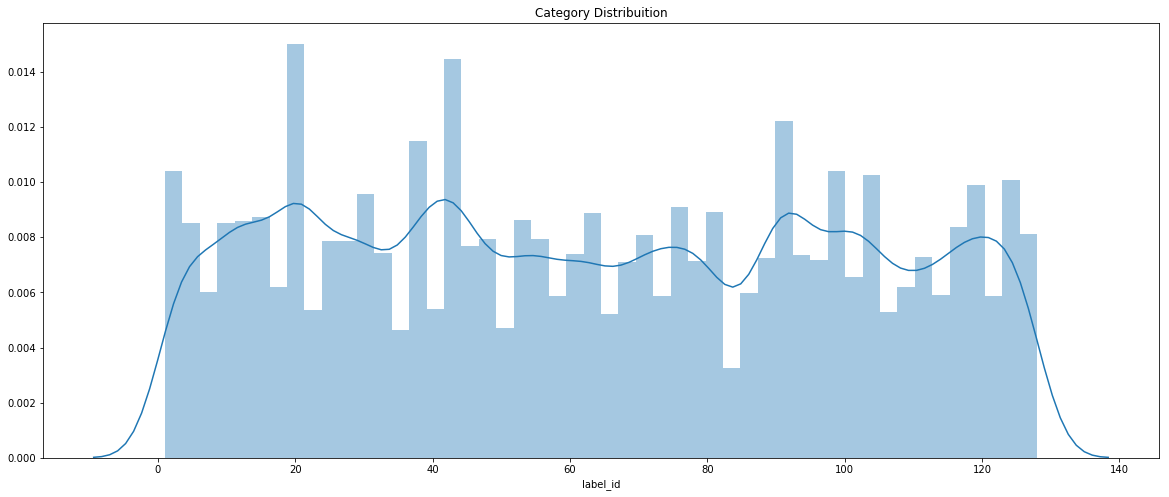

In [16]:
plt.figure(figsize = (20, 8))
plt.title('Category Distribuition')
sns.distplot(train_data['label_id'])
plt.show()

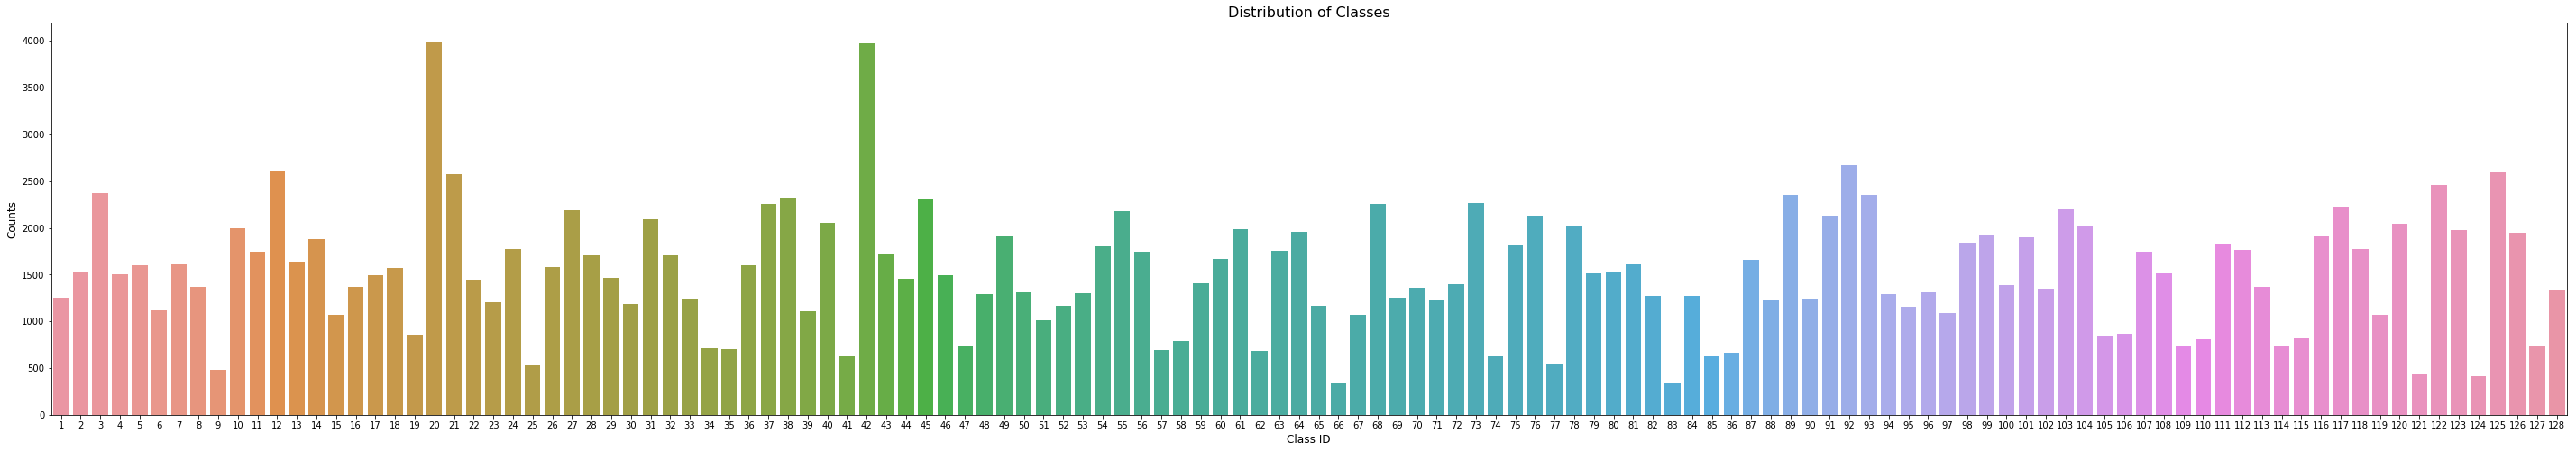

In [17]:
plt.figure(figsize=(50,8))
count = train_data['label_id'].value_counts()
sns.barplot(count.index,  count.values)
plt.xlabel('Class ID', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title("Distribution of Classes", fontsize=16)

#### Most frequent of class in training data

In [18]:
temp = pd.DataFrame(train_data.label_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['label_id','count']
temp.head(10)

,label_id,count
0,20,3996
1,42,3973
2,92,2666
3,12,2609
4,125,2598
5,21,2577
6,122,2462
7,3,2368
8,89,2353
9,93,2350


#### Least frequent of class in training data

In [19]:
temp.sort_values(by='count', ascending=True).head(10)

,label_id,count
127,83,332
126,66,342
125,124,415
124,121,442
123,9,477
122,25,527
121,77,543
120,85,621
119,41,625
118,74,629


### Distribution of validation data 

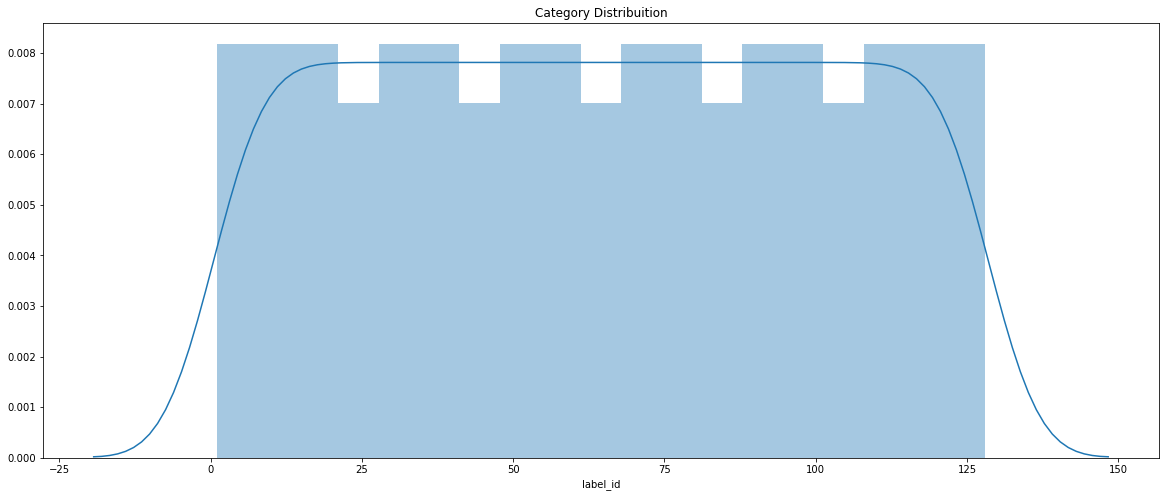

In [20]:
plt.figure(figsize = (20, 8))
plt.title('Category Distribuition')
sns.distplot(val_data['label_id'])
plt.show()

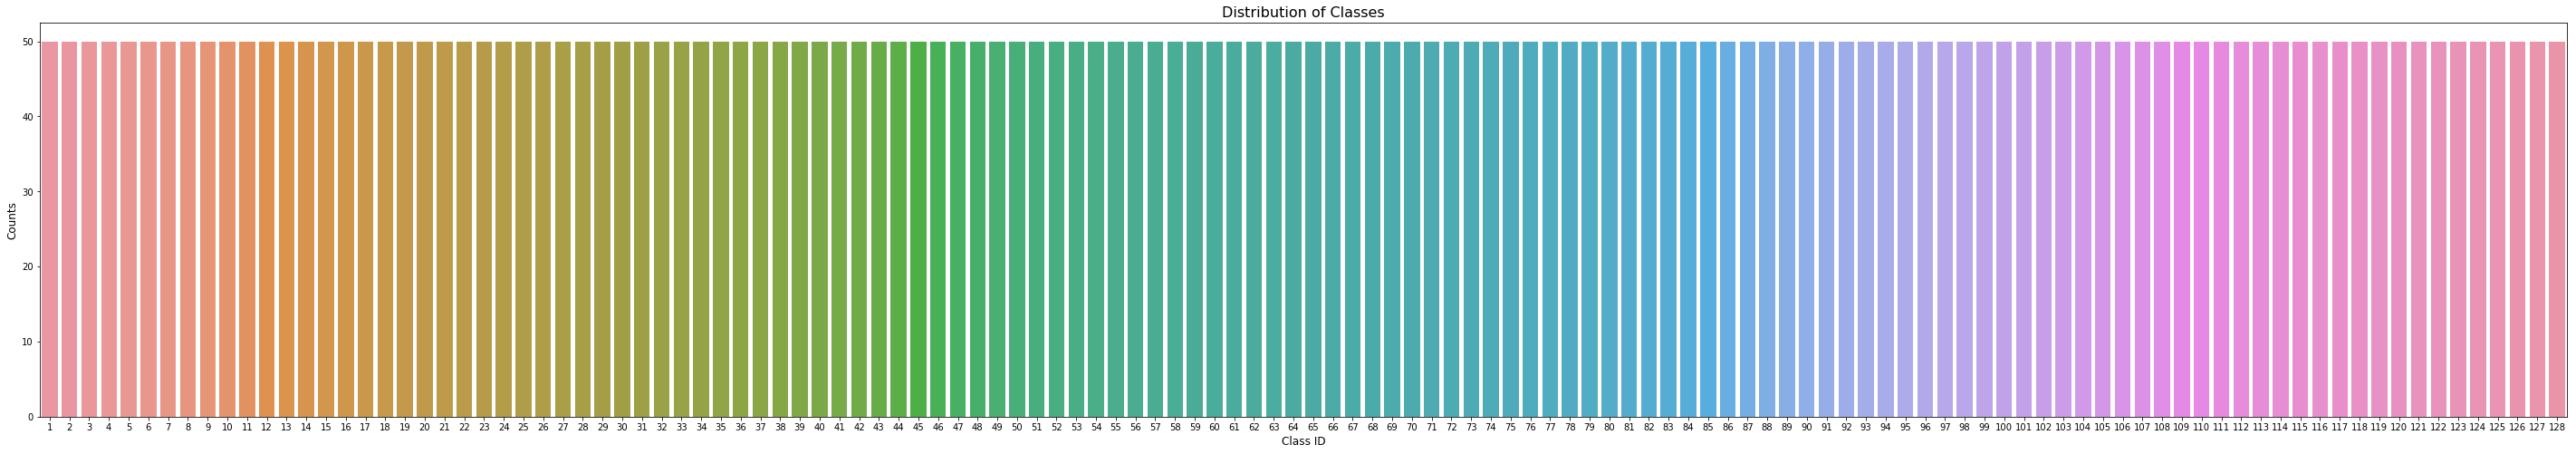

In [21]:
plt.figure(figsize=(50,8))
count = val_data['label_id'].value_counts()
sns.barplot(count.index,  count.values)
plt.xlabel('Class ID', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title("Distribution of Classes", fontsize=16)

### Extract website name

In [22]:
train_data['website'] = [(url.split('//', 1)[1]).split('/', 1)[0] for url in train_data['url']]
test_data['website'] = [(url.split('//', 1)[1]).split('/', 1)[0] for url in test_data['url']]
val_data['website'] = [(url.split('//', 1)[1]).split('/', 1)[0] for url in val_data['url']]
print('Train shape:{0} Val Shape{1} Test shape{2}'.format(train_data.shape, val_data.shape, test_data.shape))

Train shape:(194828, 4) Val Shape(6400, 4) Test shape(12800, 3)


In [23]:
train_data.head()

,image_id,label_id,url,website
0,1,5,https://img13.360buyimg.com/imgzone/jfs/t2857/...,img13.360buyimg.com
1,2,5,http://www.tengdakeli.cn/350/timg01/uploaded/i...,www.tengdakeli.cn
2,3,5,https://img13.360buyimg.com/imgzone/jfs/t8899/...,img13.360buyimg.com
3,4,5,http://img4.tbcdn.cn/tfscom/i1/2855447419/TB2S...,img4.tbcdn.cn
4,5,5,http://a.vpimg4.com/upload/merchandise/287883/...,a.vpimg4.com


In [24]:
test_data.head()

,image_id,url,website
0,1,https://img13.360buyimg.com/imgzone/jfs/t13174...,img13.360buyimg.com
1,2,http://img35.ddimg.cn/79/22/1258168705-1_u.jpg,img35.ddimg.cn
2,3,https://img.alicdn.com/imgextra/TB19HtjKXXXXXc...,img.alicdn.com
3,4,https://img13.360buyimg.com/imgzone/jfs/t16498...,img13.360buyimg.com
4,5,http://img4.99114.com/group1/M00/7D/C5/wKgGTFf...,img4.99114.com


#### Top occurances of websites in training data

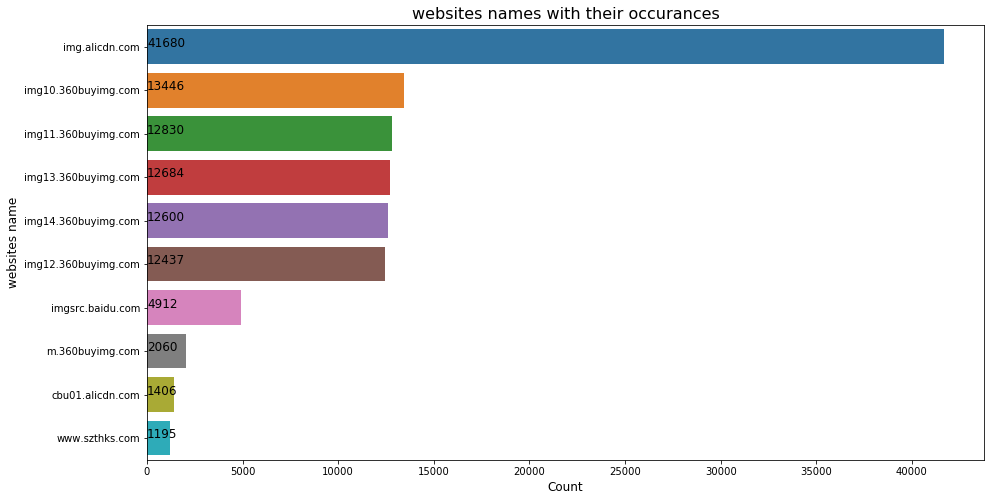

In [25]:
plt.figure(figsize=(15,8))
count = train_data.website.value_counts().head(10)
sns.barplot(count.values, count.index)
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.ylabel('websites name', fontsize=12)
plt.title("websites names with their occurances", fontsize=16)

#### Top occurances of websites in validation data

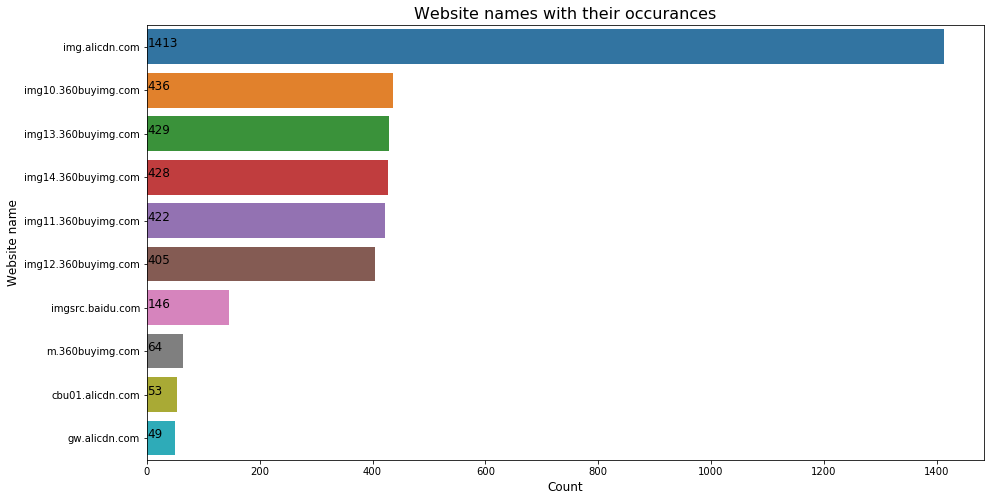

In [26]:
plt.figure(figsize=(15,8))
count = val_data.website.value_counts().head(10)
sns.barplot(count.values, count.index)
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Website name', fontsize=12)
plt.title("Website names with their occurances", fontsize=16)

#### Top occurances of websites in test data

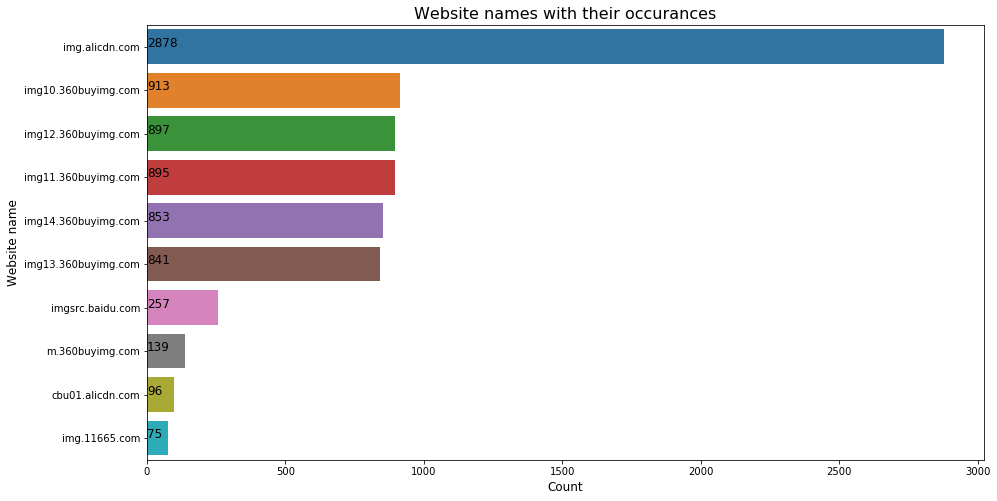

In [27]:
plt.figure(figsize=(15,8))
count = test_data.website.value_counts().head(10)
sns.barplot(count.values, count.index)
for i, v in enumerate(count.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Website name', fontsize=12)
plt.title("Website names with their occurances", fontsize=16)

## Algorithms and Techniques

#### Bilinear CNN namely BCNN for short

Since our Images have no object bounding, we need to build an end to end model, and the key of a good solution is fine-grained image classification, hence I plan to build a bilinear CNN model, which it is determined to be a good solution of the fine-grained visual classification.

#### What is BCNN?

BCNN is a recignition architecture that consists of two feature extrators whose outputs are multipled using outer product at each location of the image and pooled to obtaine an image descriptor(as cited in http://vis-www.cs.umass.edu/bcnn/docs/bcnn_iccv15.pdf).

So basically we need to use two feature extractors, namely A and B, and use the outer product of A and B as the input of FC-layer, the whole architecture as below.


![bcnn](img/bcnn.PNG)

## Benchmark

According Lin and others work[2], their bilinear CNN models include classification of birds and aircrafts and cars, they got over 80% of accuracy roughly, compare with the condition of above, this competetion we have 128 classes and 194,828 images for training, for the model that I plan to build, 80% of accuracy it could be reasonable.

# III. Methodology

## Data Preprocessing

Since I have kinds difference size of images, I have to resize all of the images to the same size as input for one model, hence I want to know which size should I use?

In [28]:
import pathlib
from PIL import Image
from tqdm import tqdm
import pandas as pd
directory = pathlib.Path('data/train')
df = pd.DataFrame(columns=['width', 'height'])
i=0
for windows_path in tqdm(list(directory.glob('*.jpg'))):
    width, height = Image.open(windows_path).size
    df.loc[len(df)] = {'width': width, 'height': height}

100%|██████████| 189934/189934 [55:24<00:00, 35.26it/s]


In [29]:
print(df.describe())

         width  height
count   189934  189934
unique    2054    2091
top        800     800
freq     98467   96811


In [30]:
print(df.mean(axis=0))

width     761.169280
height    723.012783
dtype: float64


It seems to me use the size of the image around 800x800 would be a good idea, but consider the computing costs, first I would try to resize to 96x96, and then use another size128x128 to determine if the result of bigger size is better.

Step 1.convert training images and validation images to .h5 file with RGB channel, use util.create_train_val_h5_file.

Step 2.convert test images to .h5 file with RGB channel, use util.create_train_val_h5_file.

I would have the files  as below:

1.size of 96x96:
- training.h5
- validation.h5
- test.h5

2.size of 128x128:
- training.h5
- validation.h5
- test.h5

## Implementation

In this project, I used pretrained model of VGG16. For BCNN it requires tow feature extractors, here I let two feature extractors the same, It can save the costs of training because the weights of two feature extractors are same during the training, hence I can just take the outer product of one feature extractor as the input of FC layer, instead of training two feature extractors.

Here are two model architecture and utils as below:

Model A: load weights from VGG16 and only last FC layer trainable.

Model B: load weights from Model A and the entire model trainable.

Random flip: For each batch images random flip them right to left.

Furthermore to more saving costs of training, I used two-step training as below:

Step 1: Training Model A with Momentum optimizer (learning rate=0.9,momentum=0.9).

Step 2: Training Model B with Momentum optimizer (learning rate=0.001,momentum=0.9).

### Model A architecture: use bcnn_model_architecture.bcnn_last_layer

In [38]:
import tensorflow as tf
import numpy as np


class model:

    def __init__(self, imgs, weights=None, sess=None):
        self.images = imgs
        # self.imgs=imgs
        self.last_layer_parameters = []
        self.parameters = []
        self.cnn_layers()
        self.fc_layers()
        self.weight_file = weights

    def cnn_layers(self):

        # conv1_1
        with tf.name_scope('conv1_1') as scope:
            weights = tf.Variable(tf.truncated_normal([3, 3, 3, 64], dtype=tf.float32,
                                                      stddev=1e-1), trainable=False)
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=False)
            conv = tf.nn.conv2d(self.images, weights, [1, 1, 1, 1], padding='SAME')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_1 = tf.nn.relu(out, name=scope)
            self.parameters += [weights, biases]

        # conv1_2
        with tf.name_scope('conv1_2') as scope:
            weights = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                      stddev=1e-1), trainable=False)
            biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                                 trainable=False)
            conv = tf.nn.conv2d(self.conv1_1, weights, [1, 1, 1, 1], padding='SAME')
            out = tf.nn.bias_add(conv, biases)
            self.conv1_2 = tf.nn.relu(out, name=scope)
            self.parameters += [weights, biases]

        # pool1
        self.pool1 = tf.nn.max_pool(self.conv1_2,
                                    ksize=[1, 2, 2, 1],
                                    strides=[1, 2, 2, 1],
                                    padding='SAME',
                                    name='pool1')

        # conv2_1
        with tf.name_scope('conv2_1') as scope:
            weights = tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32,
                                                      stddev=1e-1), trainable=False)
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32),
                                 trainable=False)
            conv = tf.nn.conv2d(self.pool1, weights, [1, 1, 1, 1], padding='SAME')

            out = tf.nn.bias_add(conv, biases)
            self.conv2_1 = tf.nn.relu(out, name=scope)
            self.parameters += [weights, biases]

        # conv2_2
        with tf.name_scope('conv2_2') as scope:
            weights = tf.Variable(tf.truncated_normal([3, 3, 128, 128], dtype=tf.float32,
                                                      stddev=1e-1), trainable=False)
            biases = tf.Variable(tf.constant(0.0, shape=[128], dtype=tf.float32), trainable=False)
            conv = tf.nn.conv2d(self.conv2_1, weights, [1, 1, 1, 1], padding='SAME')

            out = tf.nn.bias_add(conv, biases)
            self.conv2_2 = tf.nn.relu(out, name=scope)
            self.parameters += [weights, biases]

        # pool2
        self.pool2 = tf.nn.max_pool(self.conv2_2,
                                    ksize=[1, 2, 2, 1],
                                    strides=[1, 2, 2, 1],
                                    padding='SAME',
                                    name='pool2')

        # conv3_1
        with tf.name_scope('conv3_1') as scope:
            weights = tf.Variable(tf.truncated_normal([3, 3, 128, 256], dtype=tf.float32,
                                                      stddev=1e-1), trainable=False)
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=False)

            conv = tf.nn.conv2d(self.pool2, weights, [1, 1, 1, 1], padding='SAME')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_1 = tf.nn.relu(out, name=scope)
            self.parameters += [weights, biases]

        # conv3_2
        with tf.name_scope('conv3_2') as scope:
            weights = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                      stddev=1e-1), trainable=False)
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=False)
            conv = tf.nn.conv2d(self.conv3_1, weights, [1, 1, 1, 1], padding='SAME')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_2 = tf.nn.relu(out, name=scope)
            self.parameters += [weights, biases]

        # conv3_3
        with tf.name_scope('conv3_3') as scope:
            weights = tf.Variable(tf.truncated_normal([3, 3, 256, 256], dtype=tf.float32,
                                                      stddev=1e-1), trainable=False)
            biases = tf.Variable(tf.constant(0.0, shape=[256], dtype=tf.float32),
                                 trainable=False)

            conv = tf.nn.conv2d(self.conv3_2, weights, [1, 1, 1, 1], padding='SAME')
            out = tf.nn.bias_add(conv, biases)
            self.conv3_3 = tf.nn.relu(out, name=scope)
            self.parameters += [weights, biases]

        # pool3
        self.pool3 = tf.nn.max_pool(self.conv3_3,
                                    ksize=[1, 2, 2, 1],
                                    strides=[1, 2, 2, 1],
                                    padding='SAME',
                                    name='pool3')

        # conv4_1
        with tf.name_scope('conv4_1') as scope:
            weights = tf.Variable(tf.truncated_normal([3, 3, 256, 512], dtype=tf.float32,
                                                      stddev=1e-1), trainable=False)
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=False)

            conv = tf.nn.conv2d(self.pool3, weights, [1, 1, 1, 1], padding='SAME')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_1 = tf.nn.relu(out, name=scope)
            self.parameters += [weights, biases]

        # conv4_2
        with tf.name_scope('conv4_2') as scope:
            weights = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                      stddev=1e-1), trainable=False)
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=False)
            conv = tf.nn.conv2d(self.conv4_1, weights, [1, 1, 1, 1], padding='SAME')

            out = tf.nn.bias_add(conv, biases)
            self.conv4_2 = tf.nn.relu(out, name=scope)
            self.parameters += [weights, biases]

        # conv4_3
        with tf.name_scope('conv4_3') as scope:
            weights = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                      stddev=1e-1), trainable=False)
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=False)
            conv = tf.nn.conv2d(self.conv4_2, weights, [1, 1, 1, 1], padding='SAME')
            out = tf.nn.bias_add(conv, biases)
            self.conv4_3 = tf.nn.relu(out, name=scope)
            self.parameters += [weights, biases]

        # pool4
        self.pool4 = tf.nn.max_pool(self.conv4_3,
                                    ksize=[1, 2, 2, 1],
                                    strides=[1, 2, 2, 1],
                                    padding='SAME',
                                    name='pool4')

        # conv5_1
        with tf.name_scope('conv5_1') as scope:
            weights = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                      stddev=1e-1), trainable=False)
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=False)
            conv = tf.nn.conv2d(self.pool4, weights, [1, 1, 1, 1], padding='SAME')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_1 = tf.nn.relu(out, name=scope)
            self.parameters += [weights, biases]

        # conv5_2
        with tf.name_scope('conv5_2') as scope:
            weights = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                      stddev=1e-1), trainable=False)
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=False)
            conv = tf.nn.conv2d(self.conv5_1, weights, [1, 1, 1, 1], padding='SAME')
            out = tf.nn.bias_add(conv, biases)
            self.conv5_2 = tf.nn.relu(out, name=scope)
            self.parameters += [weights, biases]

        # conv5_3
        with tf.name_scope('conv5_3') as scope:
            weights = tf.Variable(tf.truncated_normal([3, 3, 512, 512], dtype=tf.float32,
                                                      stddev=1e-1), trainable=False)
            conv = tf.nn.conv2d(self.conv5_2, weights, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[512], dtype=tf.float32),
                                 trainable=False)
            out = tf.nn.bias_add(conv, biases)
            self.conv5_3 = tf.nn.relu(out, name=scope)
            self.parameters += [weights, biases]

        print('Shape of conv5_3', self.conv5_3.get_shape())
        self.phi_I = tf.einsum('ijkm,ijkn->imn', self.conv5_3, self.conv5_3)
        print('Shape of phi_I after einsum', self.phi_I.get_shape())

        self.phi_I = tf.reshape(self.phi_I, [-1, 512 * 512])
        print('Shape of phi_I after reshape', self.phi_I.get_shape())

        self.phi_I = tf.divide(self.phi_I, 784.0)
        print('Shape of phi_I after division', self.phi_I.get_shape())

        self.y_ssqrt = tf.multiply(tf.sign(self.phi_I), tf.sqrt(tf.abs(self.phi_I) + 1e-12))
        print('Shape of y_ssqrt', self.y_ssqrt.get_shape())

        self.z_l2 = tf.nn.l2_normalize(self.y_ssqrt, axis=1)
        print('Shape of z_l2', self.z_l2.get_shape())

    def fc_layers(self):

        with tf.name_scope('fc-new') as scope:
            fc3w = tf.get_variable('weights', [512 * 512, 128], initializer=tf.contrib.layers.xavier_initializer(),
                                   trainable=True)
            fc3b = tf.get_variable("b", [128], initializer=tf.constant_initializer(0.1), trainable=True)
            self.fc3l = tf.nn.bias_add(tf.matmul(self.z_l2, fc3w), fc3b)
            self.last_layer_parameters += [fc3w, fc3b]
            self.parameters += [fc3w, fc3b]

    def load_weights(self, sess):
        weights = np.load(self.weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            removed_layer_variables = ['fc6_W', 'fc6_b', 'fc7_W', 'fc7_b', 'fc8_W', 'fc8_b']
            if not k in removed_layer_variables:
                print(k)
                print("", i, k, np.shape(weights[k]))
                sess.run(self.parameters[i].assign(weights[k]))

### Model B architecture: use bcnn_model_architecture.bcnn_full_layer

In [39]:
import tensorflow as tf
import numpy as np


class model:
    def __init__(self, imgs, weights=None, sess=None):
        self.images = imgs
        self.imgs = imgs
        self.last_layer_parameters = []  
        self.parameters = []  
        self.convlayers()
        self.fc_layers()
        self.weight_file = weights

    def convlayers(self):
        # conv1_1
        with tf.variable_scope("conv1_1"):
            weights = tf.get_variable("W", [3, 3, 3, 64], initializer=tf.contrib.layers.xavier_initializer(),
                                      trainable=True)
            # Create variable named "biases".
            biases = tf.get_variable("b", [64], initializer=tf.constant_initializer(0.1), trainable=True)
            conv = tf.nn.conv2d(self.images, weights, strides=[1, 1, 1, 1], padding='SAME')
            self.conv1_1 = tf.nn.relu(conv + biases)
            self.parameters += [weights, biases]

        # conv1_2
        with tf.variable_scope("conv1_2"):
            weights = tf.get_variable("W", [3, 3, 64, 64], initializer=tf.contrib.layers.xavier_initializer(),
                                      trainable=True)
            # Create variable named "biases".
            biases = tf.get_variable("b", [64], initializer=tf.constant_initializer(0.1), trainable=True)
            conv = tf.nn.conv2d(self.conv1_1, weights, strides=[1, 1, 1, 1], padding='SAME')
            self.conv1_2 = tf.nn.relu(conv + biases)
            self.parameters += [weights, biases]

        # pool1
        self.pool1 = tf.nn.max_pool(self.conv1_2,
                                    ksize=[1, 2, 2, 1],
                                    strides=[1, 2, 2, 1],
                                    padding='SAME',
                                    name='pool1')

        # conv2_1
        with tf.variable_scope("conv2_1"):
            weights = tf.get_variable("W", [3, 3, 64, 128], initializer=tf.contrib.layers.xavier_initializer(),
                                      trainable=True)
            biases = tf.get_variable("b", [128], initializer=tf.constant_initializer(0.1), trainable=True)
            conv = tf.nn.conv2d(self.pool1, weights, strides=[1, 1, 1, 1], padding='SAME')
            self.conv2_1 = tf.nn.relu(conv + biases)
            self.parameters += [weights, biases]

        # conv2_2
        with tf.variable_scope("conv2_2"):
            weights = tf.get_variable("W", [3, 3, 128, 128], initializer=tf.contrib.layers.xavier_initializer(),
                                      trainable=True)
            biases = tf.get_variable("b", [128], initializer=tf.constant_initializer(0.1), trainable=True)
            conv = tf.nn.conv2d(self.conv2_1, weights, strides=[1, 1, 1, 1], padding='SAME')
            self.conv2_2 = tf.nn.relu(conv + biases)
            self.parameters += [weights, biases]

        # pool2
        self.pool2 = tf.nn.max_pool(self.conv2_2,
                                    ksize=[1, 2, 2, 1],
                                    strides=[1, 2, 2, 1],
                                    padding='SAME',
                                    name='pool2')

        # conv3_1
        with tf.variable_scope("conv3_1"):
            weights = tf.get_variable("W", [3, 3, 128, 256], initializer=tf.contrib.layers.xavier_initializer(),
                                      trainable=True)
            biases = tf.get_variable("b", [256], initializer=tf.constant_initializer(0.1), trainable=True)
            conv = tf.nn.conv2d(self.pool2, weights, strides=[1, 1, 1, 1], padding='SAME')
            self.conv3_1 = tf.nn.relu(conv + biases)
            self.parameters += [weights, biases]

        # conv3_2
        with tf.variable_scope("conv3_2"):
            weights = tf.get_variable("W", [3, 3, 256, 256], initializer=tf.contrib.layers.xavier_initializer(),
                                      trainable=True)
            biases = tf.get_variable("b", [256], initializer=tf.constant_initializer(0.1), trainable=True)
            conv = tf.nn.conv2d(self.conv3_1, weights, strides=[1, 1, 1, 1], padding='SAME')
            self.conv3_2 = tf.nn.relu(conv + biases)
            self.parameters += [weights, biases]

        # conv3_3
        with tf.variable_scope("conv3_3"):
            weights = tf.get_variable("W", [3, 3, 256, 256], initializer=tf.contrib.layers.xavier_initializer(),
                                      trainable=True)
            biases = tf.get_variable("b", [256], initializer=tf.constant_initializer(0.1), trainable=True)
            conv = tf.nn.conv2d(self.conv3_2, weights, strides=[1, 1, 1, 1], padding='SAME')
            self.conv3_3 = tf.nn.relu(conv + biases)
            self.parameters += [weights, biases]

        # pool3
        self.pool3 = tf.nn.max_pool(self.conv3_3,
                                    ksize=[1, 2, 2, 1],
                                    strides=[1, 2, 2, 1],
                                    padding='SAME',
                                    name='pool3')

        # conv4_1
        with tf.variable_scope("conv4_1"):
            weights = tf.get_variable("W", [3, 3, 256, 512], initializer=tf.contrib.layers.xavier_initializer(),
                                      trainable=True)
            biases = tf.get_variable("b", [512], initializer=tf.constant_initializer(0.1), trainable=True)
            conv = tf.nn.conv2d(self.pool3, weights, strides=[1, 1, 1, 1], padding='SAME')
            self.conv4_1 = tf.nn.relu(conv + biases)
            self.parameters += [weights, biases]

        # conv4_2
        with tf.variable_scope("conv4_2"):
            weights = tf.get_variable("W", [3, 3, 512, 512], initializer=tf.contrib.layers.xavier_initializer(),
                                      trainable=True)
            biases = tf.get_variable("b", [512], initializer=tf.constant_initializer(0.1), trainable=True)
            conv = tf.nn.conv2d(self.conv4_1, weights, strides=[1, 1, 1, 1], padding='SAME')
            self.conv4_2 = tf.nn.relu(conv + biases)
            self.parameters += [weights, biases]

        # conv4_3
        with tf.variable_scope("conv4_3"):
            weights = tf.get_variable("W", [3, 3, 512, 512], initializer=tf.contrib.layers.xavier_initializer(),
                                      trainable=True)
            biases = tf.get_variable("b", [512], initializer=tf.constant_initializer(0.1), trainable=True)
            conv = tf.nn.conv2d(self.conv4_2, weights, strides=[1, 1, 1, 1], padding='SAME')
            self.conv4_3 = tf.nn.relu(conv + biases)
            self.parameters += [weights, biases]

        # pool4
        self.pool4 = tf.nn.max_pool(self.conv4_3,
                                    ksize=[1, 2, 2, 1],
                                    strides=[1, 2, 2, 1],
                                    padding='SAME',
                                    name='pool4')

        # conv5_1
        with tf.variable_scope("conv5_1"):
            weights = tf.get_variable("W", [3, 3, 512, 512], initializer=tf.contrib.layers.xavier_initializer(),
                                      trainable=True)
            biases = tf.get_variable("b", [512], initializer=tf.constant_initializer(0.1), trainable=True)
            conv = tf.nn.conv2d(self.pool4, weights, strides=[1, 1, 1, 1], padding='SAME')
            self.conv5_1 = tf.nn.relu(conv + biases)
            self.parameters += [weights, biases]

        # conv5_2
        with tf.variable_scope("conv5_2"):
            weights = tf.get_variable("W", [3, 3, 512, 512], initializer=tf.contrib.layers.xavier_initializer(),
                                      trainable=True)
            biases = tf.get_variable("b", [512], initializer=tf.constant_initializer(0.1), trainable=True)
            conv = tf.nn.conv2d(self.conv5_1, weights, strides=[1, 1, 1, 1], padding='SAME')
            self.conv5_2 = tf.nn.relu(conv + biases)
            self.parameters += [weights, biases]

        # conv5_3
        with tf.variable_scope("conv5_3"):
            weights = tf.get_variable("W", [3, 3, 512, 512], initializer=tf.contrib.layers.xavier_initializer(),
                                      trainable=True)
            biases = tf.get_variable("b", [512], initializer=tf.constant_initializer(0.1), trainable=True)
            conv = tf.nn.conv2d(self.conv5_2, weights, strides=[1, 1, 1, 1], padding='SAME')
            self.conv5_3 = tf.nn.relu(conv + biases)

            self.parameters += [weights, biases]

        print('Shape of conv5_3', self.conv5_3.get_shape())
        self.phi_I = tf.einsum('ijkm,ijkn->imn', self.conv5_3, self.conv5_3)
        print('Shape of phi_I after einsum', self.phi_I.get_shape())
        self.phi_I = tf.reshape(self.phi_I, [-1, 512 * 512])

        print('Shape of phi_I after reshape', self.phi_I.get_shape())

        self.phi_I = tf.divide(self.phi_I, 784.0)

        print('Shape of phi_I after division', self.phi_I.get_shape())

        self.y_ssqrt = tf.multiply(tf.sign(self.phi_I), tf.sqrt(tf.abs(self.phi_I) + 1e-12))
        print('Shape of y_ssqrt', self.y_ssqrt.get_shape())

        self.z_l2 = tf.nn.l2_normalize(self.y_ssqrt, dim=1)
        print('Shape of z_l2', self.z_l2.get_shape())

    def fc_layers(self):
        with tf.variable_scope('fc-new') as scope:
            fc3w = tf.get_variable('W', [512 * 512, 128], initializer=tf.contrib.layers.xavier_initializer(),
                                   trainable=True)
            fc3b = tf.get_variable("b", [128], initializer=tf.constant_initializer(0.1), trainable=True)
            self.fc3l = tf.nn.bias_add(tf.matmul(self.z_l2, fc3w), fc3b)
            self.last_layer_parameters += [fc3w, fc3b]

    def load_initial_weights(self, session):
        weights_dict = np.load(self.weight_file, encoding='bytes')
        vgg_layers = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2', 'conv3_3', 'conv4_1', 'conv4_2',
                      'conv4_3', 'conv5_1', 'conv5_2', 'conv5_3']

        for op_name in vgg_layers:
            with tf.variable_scope(op_name, reuse=True):
                var = tf.get_variable('b', trainable=True)
                print('Adding weights to', var.name)
                session.run(var.assign(weights_dict[op_name + '_b']))
                var = tf.get_variable('W', trainable=True)
                print('Adding weights to', var.name)
                session.run(var.assign(weights_dict[op_name + '_W']))

        with tf.variable_scope('fc-new', reuse=True):
            last_layer_weights = np.load('last_layers_epoch_128.npz')
            print('Last layer weights: last_layers_epoch_128.npz')
            var = tf.get_variable('W', trainable=True)
            print('Adding weights to', var.name)
            session.run(var.assign(last_layer_weights['arr_0'][0]))
            var = tf.get_variable('b', trainable=True)
            print('Adding weights to', var.name)
            session.run(var.assign(last_layer_weights['arr_0'][1]))


### Random flip: use utils.utils.random_flip_right_to_left

In [1]:
def random_flip_right_to_left(image_batch):
    result = []
    for n in range(image_batch.shape[0]):
        if bool(random.getrandbits(1)):
            result.append(image_batch[n][:, ::-1, :])
        else:
            result.append(image_batch[n])
    return result

## Refinement

In this project here are two main processes:

1.First step training use main.first_step_training:

    - import model A and load VGG16 weights.
    
    - after trained model A with 100 epochs.
    
    - extract weights of model A and save to weights file.
    
    - output prediction.
    
2.Second step training use main.second_step_training:

    - import model B and load weights from model A.
    
    - training model B, and check if model overfitting during the training period.
    
    - extract weights of model B and save to weights file.
    
    - output prediction.

# IV. Results

# Model Evaluation and Validation

At first, I resize images to 96x96 and after 62 epochs training, model got overfitting, and I got accuracy around 76%.

And then I resize images to 128x128 and after 30 epochs training, model got overfitting, and I got accuracy around 78%.

All the accuracy as above are evaluated by upload predict result to Kaggle, for the detail see as below:

![kaggle](img/kaggle.PNG)

## Justification

The final results I got the accuracy is around 78% with image size 128x128.

Compare to the accuracy of benchmark  is over 80%, it seems not good enough, but consider the result from image size of 96x96 accuracy is 76%, hence I expected if increase the image size, the accuracy would be improve to over 80%.


| benchmark model         | model with 96x96 image size | model with 128x128 image size |
|-------------------------|-----------------------------|-------------------------------|
|   accuracy over 80%     |         accuracy: 76%       |   accuracy: 78%               |

# V. Conclusion

## Free-Form Visualization

### optimizer:

In this project consider the amounts of training data and compare to our target categories, I think the input data is not sparse, we should not use adaptive learning-rate methods, such as RMSprop or Adam[3].

Hence I use momentum optimizer to accelerate training, but if we want to more approach the optimal, maybe we could try SGD optimizer.

See SGD optimization on loss surface contours as belowe[3]:

![optimizers](img/contours_evaluation_optimizers.gif)

## Reflection

This project is a competition from Kaggle, and all the data we need to download from URLs that Kaggle provided,
hence the first we need to write program to download all these images automatically.

After finish download all these images, we have kinds of different size of image, hence the first we need to resize all the image, then convert these images to .h5 file, and implement the BCNN architecture specifically is the architecture of BCNN[D,D] [2], the interesting thing is I can just take the outer product of one feature extractor as the input of FC layer, because the weights of two feature extractors are same during the training.

The most difficult thing I think is saving the costs of computing, for this competition I already spents over 200 dollars on the GCP.

I think at begining I should use very small portion of images to figure out whitch size of image is good and affordable to computing.


## Improvement

Here are some idea I think that would improve the result:

1. Increase Image size: I got the image mean size arround 800x800, and I tried two different image size from 96x96 to 128x128 the accuracy is increase, hence I expect increase image size is helpful.

2. Shuffling the training data after every epoch: I have tried to do this but unfortunately memory is not affordable.

3. Use SGD optimizer: Generally if training data is big I think use SGD optimizer is most likely to approach optimal.

# VI. References


[1] https://www.kaggle.com/c/imaterialist-challenge-furniture-2018

[2] T.-Y. Lin, A. RoyChowdhury, and S. Maji. Bilinear CNN models for fine-grained visual recognition. In Proceedings of IEEE International Conference on Computer Vision, pages 1449–1457, Sandiago, Chile, Dec. 2015.

[3] http://ruder.io/optimizing-gradient-descent/